In [1]:
import pandas as pd
import itertools
import re
import numpy as np
import sys
import os

In [2]:
# Read data from file into DataFrame
df = pd.read_table('***/train/Input_data.txt', sep = '\t')
df

,sgRNA,Efficiency,epigenetics information
0,TCTCCCGCCGACCTAAGCCC,91.0,0.1630
1,AGAAAGCCGAGCAGCAGCAG,93.0,0.4380
2,TCCTGCAGCTCCTTTCCCAG,85.0,0.5190
3,ACGTGACTTTGATCGTGGAG,39.5,0.1320
4,AGGTTTTGCAAGCACATTCC,53.5,0.1160
...,...,...,...
200,CAGAGAGGAGAAGGTGTCCG,12.0,0.0813
201,GCTCTGGTATCAGGAGACCG,83.0,0.1470
202,GACAGGGGCAGAAAGCCAAG,73.0,0.1010
203,GCCCAAGGAGACCCAGAACT,72.0,0.0387


In [13]:
# Generate position-specific features
def position_specific(df, order, nucleotides):
    ret_def = pd.DataFrame()
    for ord_ in range(1, order + 1):
        for p in itertools.product(nucleotides, repeat=ord_):
            p = ''.join(p) 
            for i in range(0, len(df['sgRNA'][0]) - ord_ + 1):
                col_name = p + '_' + str(i + 1)
                ret_def[col_name] = pd.Series(data=(df.shape[0] * [0])).astype(np.int8)
            print('Finding positions for ' + p)
            idx = 0
            for sgRNA in df['sgRNA']:
                for m in re.finditer('(?=' + p + ')', sgRNA):
                    col_name = p + '_' + str(m.start() + 1)
                    ret_def[col_name].at[idx] = np.int8(1)
                idx += 1
    return ret_def
nucleotides_ = ['A', 'C', 'T', 'G']
df_pos_spe = position_specific(df, 2, nucleotides_).astype(np.int8)

Finding positions for A
Finding positions for C
Finding positions for T
Finding positions for G
Finding positions for AA
Finding positions for AC


Finding positions for AT
Finding positions for AG
Finding positions for CA
Finding positions for CC
Finding positions for CT
Finding positions for CG
Finding positions for TA
Finding positions for TC
Finding positions for TT
Finding positions for TG
Finding positions for GA
Finding positions for GC
Finding positions for GT
Finding positions for GG


C:\Users\au735018\AppData\Local\Temp\ipykernel_11380\4244551909.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_def[col_name] = pd.Series(data=(df.shape[0] * [0])).astype(np.int8)
C:\Users\au735018\AppData\Local\Temp\ipykernel_11380\4244551909.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_def[col_name] = pd.Series(data=(df.shape[0] * [0])).astype(np.int8)
C:\Users\au735018\AppData\Local\Temp\ipykernel_11380\4244551909.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

In [14]:
# Apply function to calculate Tm for each sgRNAs
from Bio.SeqUtils import MeltingTemp as mt
def calculate_row_tm(sequence):
    # 计算Tm值
    tm = mt.Tm_Wallace(sequence)
    return int(tm)
    
df_Tm = df['sgRNA'].apply(calculate_row_tm)

In [15]:
# Apply function to calculate GC content for each sgRNAs
from Bio.SeqUtils import GC
def calculate_row_gc(sequence):
    # 计算Tm值
    gc = GC(sequence)
    return int(gc)
    
    # 在DataFrame中应用函数，计算每行的Tm值
df_GC = df['sgRNA'].apply(calculate_row_gc)

In [6]:
# Add position-specific features, Tm and GC content columns to DataFrame("for multi-features model")
df['Tm'] =df_Tm
df['GC_contect'] = df_GC
df = pd.concat([df,df_pos_spe],axis=1)


# Set sgRNA column as index
df = df.set_index('sgRNA',inplace=False)
df

,Efficiency,epigenetics,Tm,GC_contect,A_1,A_2,A_3,A_4,A_5,A_6,...,GG_10,GG_11,GG_12,GG_13,GG_14,GG_15,GG_16,GG_17,GG_18,GG_19
sgRNA,,,,,,,,,,,,,,,,,,,,,
TCTCCCGCCGACCTAAGCCC,91.0,0.1630,68,70,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGAAAGCCGAGCAGCAGCAG,93.0,0.4380,64,60,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
TCCTGCAGCTCCTTTCCCAG,85.0,0.5190,64,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACGTGACTTTGATCGTGGAG,39.5,0.1320,60,50,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
AGGTTTTGCAAGCACATTCC,53.5,0.1160,58,45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAGAGAGGAGAAGGTGTCCG,12.0,0.0813,64,60,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
GCTCTGGTATCAGGAGACCG,83.0,0.1470,64,60,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
GACAGGGGCAGAAAGCCAAG,73.0,0.1010,64,60,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Convert position columns to numeric format
position_columns = [col for col in df.columns if '_' in col]
df[position_columns] = df[position_columns].apply(pd.to_numeric)

In [8]:
# Split data into train and test sets
# For the "single-feature model", only seqence one-hot encode was considered. 
# Use same random seed to divide training set and test set
from sklearn.model_selection import train_test_split
score_type='Efficiency'

#exclude_columns = ['epigenetics', 'Tm', 'GC_content', 'score_type']
#predictors = [x for x in df.columns if x not in exclude_columns]
predictors = [x for x in df.columns if x!=score_type]
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[score_type], test_size=0.1, random_state=4)

In [10]:
import xgboost as xgb # direct xgboost library
from sklearn.model_selection import GridSearchCV 

In [11]:
# Define initial XGBoost estimator
init_est = xgb.XGBRegressor(learning_rate =0.01, # this is analogue to eta, Typical: 0.01-0.2
                         n_estimators=300, # the number of iterations/trees.  
                         max_depth=5, # Typical values: 3-10 
                         min_child_weight=2,
                         gamma=0, # min_split_loss
                         subsample=0.8, # the fraction of observations to be randomly samples for each tree. 0.5-1
                         colsample_bytree=0.8, # the fraction of columns to be randomly samples for each tree. 0.5-1
                         reg_alpha = 0.01,
                         seed=12, n_jobs=-1)


'''
Tune hyperparameters 
'''
def xgb_train_cv(x_train, y_train, init_estimator = init_est, n_folds = 5, scoring = 'neg_mean_squared_error'):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    param_groups = {
        '1':{ # 1. Tune max_depth and min_child_weight
            'max_depth': range(2,10),
            'min_child_weight':range(6,16)
        },
        '2':{ # 2. Tune gamma
            'gamma':[i/10.0 for i in range(0,3)]
        },
        '3':{ # 3. Tune subsample and colsample_bytree
            'subsample':[i/10.0 for i in range(4,9)],
            'colsample_bytree':[i/10.0 for i in range(2,10)]
        },
        '4':{ # 4. Tuning Regularization Parameters
            'reg_alpha':[0.0005,0.0001,0.005,0.001,0.01]
        },
        '5': { # 5. Tuning learning rate and the number of estimators
            'learning_rate':[ .1, .05, .01, .005,],
            'n_estimators': [int(x) for x in range(200,1100,100)],
        }
    }
    best_param = {}
    cv_results = {}
    best_est = init_est
    
    for k, params in param_groups.items():
        xgb_cv = GridSearchCV(estimator = best_est, param_grid = params, 
                              scoring=scoring,n_jobs=-1,cv=n_folds,return_train_score=True)
        xgb_cv.fit(x_train,y_train)
        best_param[k] = xgb_cv.best_params_
        cv_results[k] = xgb_cv.cv_results_
        
        best_est = xgb_cv.best_estimator_
        best_est.get_booster().set_param(xgb_cv.best_params_)
    
    return cv_results,best_param,best_est


In [12]:
xgb_cv_results, best_param,best_est= xgb_train_cv(X_train, y_train, init_estimator=init_est)
best_param

{'1': {'max_depth': 5, 'min_child_weight': 14},
 '2': {'gamma': 0.0},
 '3': {'colsample_bytree': 0.8, 'subsample': 0.8},
 '4': {'reg_alpha': 0.0001},
 '5': {'learning_rate': 0.01, 'n_estimators': 600}}

In [13]:
### selecting the best models by 10-iterations
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import spearmanr,pearsonr

def regression_cv(best_params, X_train, y_train, outfile=None, iteration=10, random_state=12):
   import warnings
   warnings.filterwarnings("ignore")
   cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
        
   best_xgb = xgb.XGBRegressor(**best_params)
    
   mses = []
   r2s = []
   spearman_corrs = []
    
   for n_iter in range(iteration):
       for i, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
           X_i = X_train.values[tr_idx]
           y_i = y_train.values[tr_idx]
    
           X_val_i = X_train.values[val_idx]
           y_val_i = y_train.values[val_idx]
            
           best_xgb.fit(X_i, y_i)
           y_pred = best_xgb.predict(X_val_i)
            
           mse = mean_squared_error(y_val_i, y_pred)
           r2 = r2_score(y_val_i, y_pred)
           spearman_corr = spearmanr(y_val_i, y_pred)[0]
            
           mses.append(mse)
           r2s.append(r2)
           spearman_corrs.append(spearman_corr)
    
   mean_mse = np.mean(mses)
   std_mse = np.std(mses)
   mean_r2 = np.mean(r2s)
   std_r2 = np.std(r2s)
   mean_spearman_corr = np.mean(spearman_corrs)
   std_spearman_corr = np.std(spearman_corrs)
    
   return mean_mse, std_mse, mean_r2, std_r2, mean_spearman_corr, std_spearman_corr,mses,r2s,spearman_corrs


In [14]:
# save the evaluating results
mean_mse, std_mse, mean_r2, std_r2, mean_spearman_corr, std_spearman_corr,mses,r2s,spearman_corrs= regression_cv(
    best_param, X_train, y_train, iteration=10)
df2 = pd.concat([pd.Series(mses),pd.Series(spearman_corrs)],axis=1)
#df2.to_csv("***/train/allfeature_evaluation.csv")

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier

In [16]:
# Train XGBoost model with best parameters
best_xgb = xgb.XGBRegressor(**best_param)
best_xgb.fit(X_train, y_train)

[13:17:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "1", "2", "3", "4", "5" } are not used.



XGBRegressor(1={'max_depth': 5, 'min_child_weight': 14}, 2={'gamma': 0.0},
             3={'colsample_bytree': 0.8, 'subsample': 0.8},
             4={'reg_alpha': 0.0001},
             5={'learning_rate': 0.01, 'n_estimators': 600}, base_score=None,
             booster=None, callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None, ...)

In [17]:
# Calculate MSE and Spearman correlation for the test dataset
y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred.ravel())
cor = spearmanr(y_test, y_pred.ravel())[0]
print("MSE of the test dataset:", mse)
print("Spearman correlation of the test dataset:", cor)

# Concatenate true and predicted values into DataFrame
df_pred = pd.concat([y_test,pd.Series(y_pred)],axis=1)
#df_pred.to_csv("***/train/multi-features_pred.csv")

MSE of the test dataset: 801.1313992065532
Spearman correlation of the test dataset: 0.39164048078147234


In [18]:
# Measure feature importance via retraining "multi-feature model" of above optimal parameters
best_xgb2 = xgb.XGBRegressor(**best_param)
best_xgb2.fit(df[predictors], df[score_type])
importance_all = pd.DataFrame()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    importance = best_xgb2.get_booster().get_score(importance_type=importance_type)    
    keys = list(importance.keys())    
    values = list(importance.values())    
    df_importance = pd.DataFrame(data=values, index=keys, columns=['importance_'+importance_type])    
    importance_all = pd.concat([importance_all, df_importance],axis=1)
importance_all

[13:17:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "1", "2", "3", "4", "5" } are not used.



,importance_weight,importance_gain,importance_cover,importance_total_gain,importance_total_cover
epigenetics,450.0,68.064499,10.535556,30629.023438,4741.0
Tm,164.0,25.749691,18.609756,4222.949219,3052.0
A_1,24.0,29.144464,5.875000,699.467163,141.0
A_2,33.0,46.642735,6.454545,1539.210205,213.0
A_3,28.0,4.736733,5.285714,132.628525,148.0
...,...,...,...,...,...
GG_14,2.0,2827.440430,157.500000,5654.880859,315.0
GG_15,1.0,1852.138672,29.000000,1852.138672,29.0
GG_16,3.0,0.642921,17.000000,1.928763,51.0
GG_17,1.0,3530.652344,80.000000,3530.652344,80.0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'epigenetics'),
  Text(1, 0, 'G_16'),
  Text(2, 0, 'C_14'),
  Text(3, 0, 'T_19'),
  Text(4, 0, 'TT_18'),
  Text(5, 0, 'CC_14'),
  Text(6, 0, 'TG_7'),
  Text(7, 0, 'CT_14'),
  Text(8, 0, 'GC_9'),
  Text(9, 0, 'TG_13'),
  Text(10, 0, 'TG_12'),
  Text(11, 0, 'TG_1'),
  Text(12, 0, 'GC_18'),
  Text(13, 0, 'A_15'),
  Text(14, 0, 'CA_1'),
  Text(15, 0, 'CA_18'),
  Text(16, 0, 'A_14'),
  Text(17, 0, 'GG_14'),
  Text(18, 0, 'AC_11'),
  Text(19, 0, 'A_5'),
  Text(20, 0, 'T_1'),
  Text(21, 0, 'A_9'),
  Text(22, 0, 'C_2'),
  Text(23, 0, 'Tm'),
  Text(24, 0, 'GT_13'),
  Text(25, 0, 'CC_6'),
  Text(26, 0, 'CC_11'),
  Text(27, 0, 'TG_9'),
  Text(28, 0, 'CT_2'),
  Text(29, 0, 'A_20')])

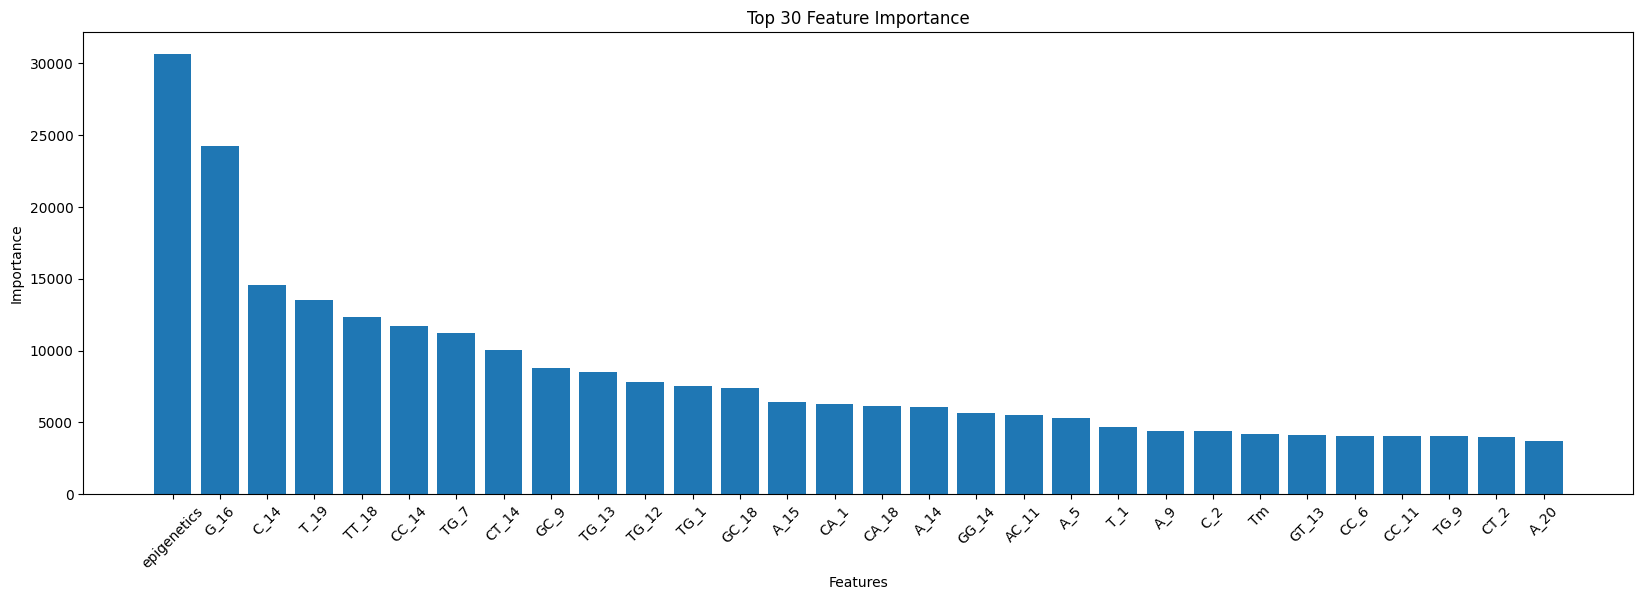

In [19]:
import matplotlib.pyplot as plt
# Get feature importance
importance = best_xgb2.get_booster().get_score(importance_type='total_gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Select top n features for visualization
n = 30
feature_names = X_train.columns
top_n_features = importance[:n]
top_n_features_names = [f[0] for f in top_n_features]
top_n_features_importance = [f[1] for f in top_n_features]
# Plot top n feature importance
plt.figure(figsize=(20, 6))
plt.bar(top_n_features_names, top_n_features_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top {} Feature Importance'.format(n))
plt.xticks(rotation=45)
#plt.savefig("***/train/gain.pdf", bbox_inches='tight', pad_inches = 0.1)

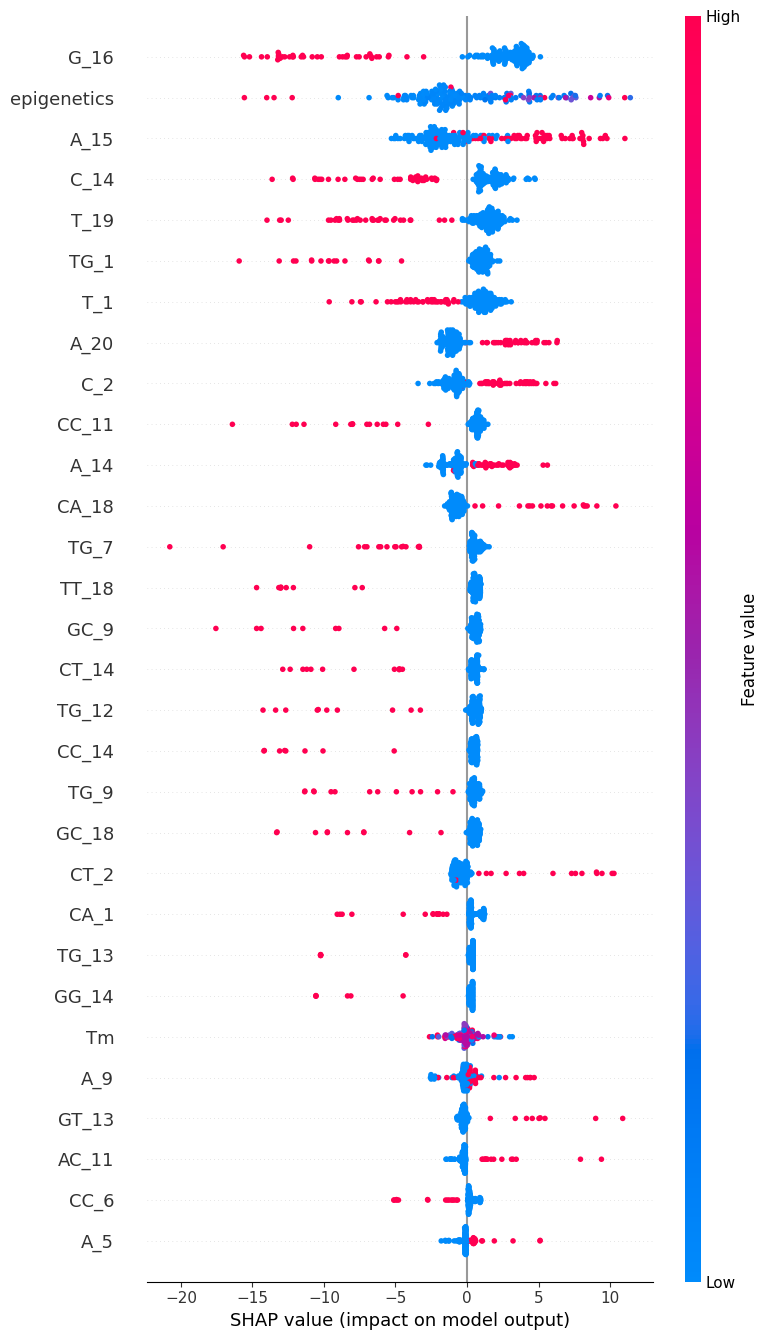

In [20]:
# Calculate SHAP values & Plot SHAP summary plot
import numpy
import numba
import shap
explainer = shap.TreeExplainer(best_xgb2) 
shap_values = explainer.shap_values(X_train)
shap_values_fl = pd.DataFrame(shap_values, columns=X_train.columns.values)
shap_values_fl = shap_values_fl[top_n_features_names]
X_train_f1 = X_train[top_n_features_names]

shap.summary_plot(np.array(shap_values_fl), X_train_f1,feature_names=top_n_features_names,show=False,max_display=30)
#plt.savefig("***/train/shap_1.pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()

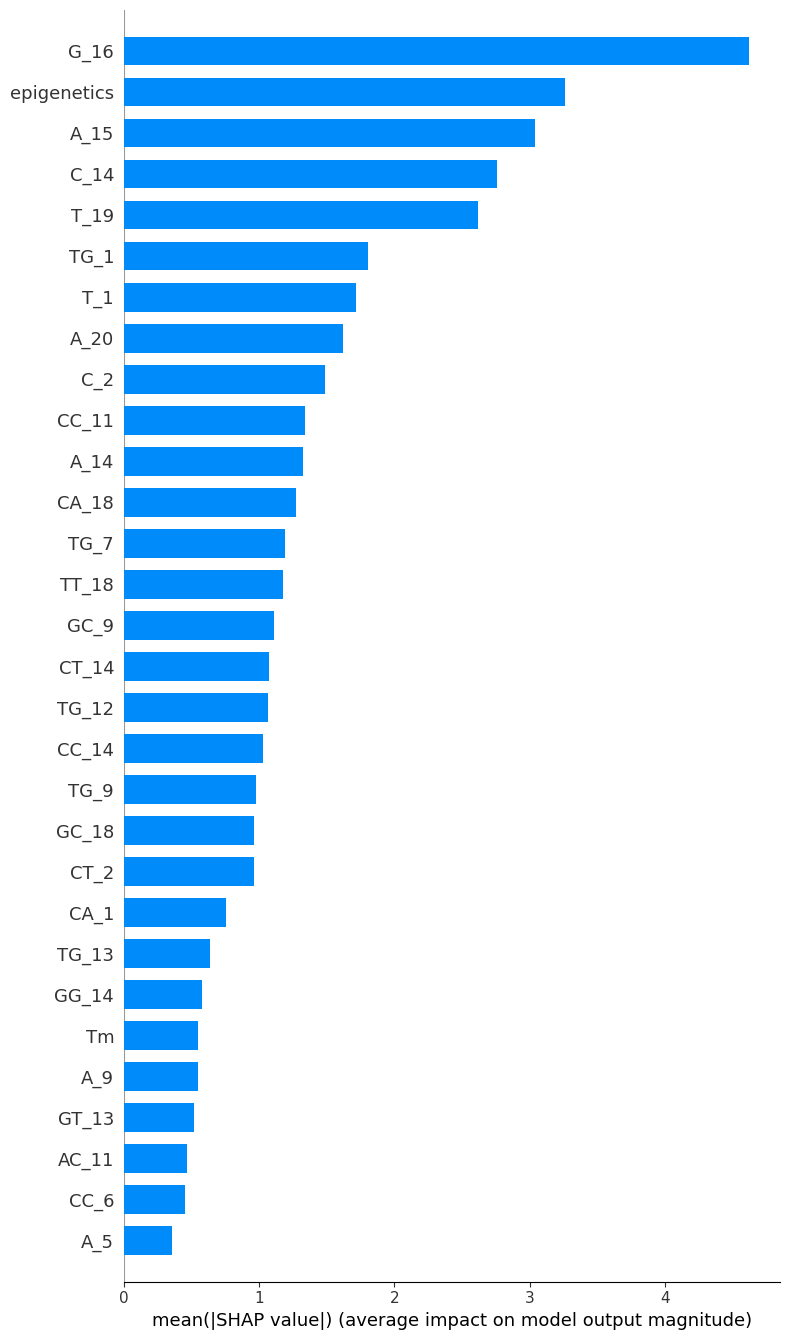

In [21]:
shap.summary_plot(np.array(shap_values_fl), X_train_f1, plot_type="bar",show=False,max_display=30)
#plt.savefig("***/train/shap_2.pdf", bbox_inches='tight', pad_inches = 0.1)
#plt.show()